### Imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

### Device.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current device: {}'.format(device))

Current device: cpu


### Dataset.

In [3]:
# Load Fashion-MNIST Dataset.
# Dataset pre-selected for training.
train_dataset = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)
# Dataset pre-selected for testing.
test_dataset = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

# Set labels.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [4]:
# We want to split the training dataset into a training dataset and a validation dataset.
# We will do this using random_split with a fixed seed to enable reproducibility.

# Check current seed. This was used once to check for the seed and that one was chosen.
#torch.Generator().seed()

# Set seed via Generator.
gen = torch.Generator()
gen.manual_seed(317112508772318)

# Use random_split with the Generator.
train_dataset, valid_dataset = random_split(train_dataset, [50000, 10000], generator = gen)

#### Check if split works as it should.

Image 38184 of 50000. Training.


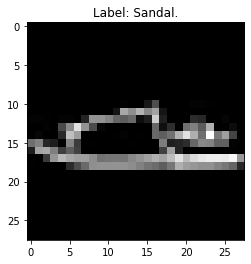

Number of training images: 50000.
Number of validation images: 10000.
Number of testing images: 10000.


In [5]:
# Borrowed code from previous assignment.

# Plot specific image, chosen at random. Should be a sandal.
dummy_index = 38184
dummy_img, dummy_label = train_dataset[dummy_index]
print("Image {} of {}. Training.".format(dummy_index, len(train_dataset)))

plt.title("Label: {}.".format(labels_map[dummy_label]))
# To not use train_dataset[dummy_index][0][0] we use squeeze, which removes dimensions of size 1.
plt.imshow(dummy_img.squeeze(), cmap = 'gray')
plt.show()

print("Number of training images: {}.".format(len(train_dataset)))
print("Number of validation images: {}.".format(len(valid_dataset)))
print("Number of testing images: {}.".format(len(test_dataset)))

### Convolutional Neural Network

In [6]:
# Convolutional Neural Network with kernel_size = 3 as a subclass of nn.Module (neural network module).
# Structure of the CNN is as follows:
# -> Convolutional layer: 
#          1 input channel -- 32 output channels
#          kernel size of 3.
#          padding of 1. This means no dimension reduction by the convolution since 1 is the "thickness" of the padding.
#       Batch Normalization -- ReLU as activation function
#       Max pooling 2d of kernel size 2 and stride = 2. This reduces image dimensions to 14 x 14.
# -> Convolutional layer: 
#          32 input channel -- 64 output channels
#          kernel size of 3.
#          padding of 0. This means dimension reduction to 12 x 12.
#       Batch Normalization -- ReLU as activation function
#       Max pooling 2d of kernel size 2 and stride = 2. This reduces image dimensions to 6 x 6.
# -> Flatten to feed to dense layer. Size of tensor = 64*6*6 = 2304
#       p_dropout dropout rate. Default is 0.1.
#       ReLU as activation function.
# -> Dense layer:
#          n_hidden_1 dense layer. Default is 600
#       p_dropout dropout rate. Default is 0.25.
#       ReLU as activation function.
# -> Dense layer:
#          n_hidden_2 dense layer. Default is 120
#       p_dropout dropout rate. Default is 0.25.
#       ReLU as activation function.
# -> 10 output layer.
#       No activation funcion since loss function used is CrossEntropyLoss
class CNN(nn.Module):
    def __init__(self, n_hidden_1 = 600, n_hidden_2 = 120, p_dropout = 0.25):
        super().__init__()
        # Name, for reference purposes.
        self.name = "CNN-Nahuel"
        # Structure.
        self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
                            nn.BatchNorm2d(32), 
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 2, stride = 2)
                            )
        
        self.conv2 = nn.Sequential(
                            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 0),
                            nn.BatchNorm2d(64), 
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 2, stride = 2)
                            )
        
        self.flatten = nn.Sequential(
                            nn.Flatten(),
                            nn.Dropout(p_dropout),
                            nn.ReLU()
                            )
        
        self.linear1 = nn.Sequential(
                            nn.Linear(64*6*6, n_hidden_1),
                            nn.Dropout(p_dropout),
                            nn.ReLU()
                            )
        
        self.linear2 = nn.Sequential(
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Dropout(p_dropout),
                            nn.ReLU()
                            )
        
        self.linear3 = nn.Linear(n_hidden_2, 10)
    
    # Method to compute output tensor from input tensor.
    def forward(self, input_tensor):
        input_tensor = self.conv1(input_tensor)
        input_tensor = self.conv2(input_tensor)
        input_tensor = self.flatten(input_tensor)
        input_tensor = self.linear1(input_tensor)
        input_tensor = self.linear2(input_tensor)
        input_tensor = self.linear3(input_tensor)
        return input_tensor

# Note: dropout is usually applied after the activation function. When using rectified linear units,
# we apply it before the activation function since in this case the order doesn't matter and it's 
# more computationally efficient.

### Training and Testing.

In [7]:
# Training function.
def train(dataloader, model, loss_function, optimizer, sample_data = False, sample_data_threshold = 20):
    if sample_data:
        num_samples_total = len(dataloader.dataset)
    # Set training mode.
    model.train()
    ##model = model.to(device) for gpu.
    # Iteration.
    for batch, (input_tensor, reference_tensor) in enumerate(dataloader):
        ###input_tensor = input_tensor.to(device) for gpu.
        ###reference_tensor = reference_tensor.to(device) for gpu.
        # Calculate output tensor and evaluate loss function.
        output_tensor = model(input_tensor)
        loss = loss_function(output_tensor, reference_tensor) 
        
        # Backpropagation using corresponding optimizer.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if sample_data:
            if batch % sample_data_threshold * len(input_tensor) == 0:
                # Get loss as a number.
                loss = loss.item()
                # Get total number of processed samples as batch number times number of samples in each batch.
                num_samples = batch * len(input_tensor)
                # Print progress.
                print("Batch: {}. Processed {}/{} samples. Loss: {:.8f}.".format(batch, num_samples, num_samples_total, loss))
                
# Testing function.
def test(dataloader, model, loss_function):
    # Get number of samples in the dataset.
    num_samples_total = len(dataloader.dataset)
    # Get number of batches.
    num_batches_total = len(dataloader)
    # Set variables for loss and correct predictions.
    total_loss = 0
    total_correct_predictions = 0
    # Set evaluation mode.
    model.eval()
    ###model = model.to(device) for gpu.
    # Disabling gradient calculation
    with torch.no_grad():
        # Iteration.
        for input_tensor, reference_tensor in dataloader:
            ###input_tensor = input_tensor.to(device) for gpu.
            ###reference_tensor = reference_tensor.to(device) for gpu.
            # Calculate output tensor and evaluate loss function.
            output_tensor = model(input_tensor)
            loss = loss_function(output_tensor, reference_tensor)
            # Add calculated loss to the total_loss variable.
            total_loss += loss.item()
            # Add number of correct predictions to the total_correct_predictions variable.
            total_correct_predictions += (output_tensor.argmax(1) == reference_tensor).type(torch.float).sum().item()
    # Calculate average loss.
    average_loss = total_loss / num_batches_total
    accuracy = 100 * total_correct_predictions / num_samples_total
    return average_loss, accuracy

### Parameter Initialization

In [8]:
# Training parameters.
learning_rate = 1e-3
batch_size = 500
num_epochs = 50

# Dataloaders; iterables over datasets.
train_dataloader = DataLoader(train_dataset, batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

# Loss function; Cross Entrpy Loss.
loss_function = nn.CrossEntropyLoss()

# DataFrame to store calculated values.
df = pd.DataFrame()
save_loss = True

# Save model variable.
save_model = True

### Training Loop

In [9]:
from datetime import datetime
print("Start time:\n{}\n".format(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

# Initialize model.
model = CNN()
# Optimizer.
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("Model: {}\n-------------------------------".format(model.name))

for epoch in range(num_epochs):
    #print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    # Train model.
    train(train_dataloader, model, loss_function, optimizer)
    # Evaluate loss function.
    train_loss, train_accuracy = test(train_dataloader, model, loss_function)
    valid_loss, valid_accuracy = test(valid_dataloader, model, loss_function)
    if save_loss:
        # Add values to DataFrame.
        df = df.append({"model": model.name, 
                        "epoch": epoch + 1, 
                        "train_loss": train_loss,
                        "train_accuracy": train_accuracy,
                        "valid_loss": valid_loss,
                        "valid_accuracy": valid_accuracy},
                        ignore_index = True)
        # Safety save.
        df.to_pickle(r"models\safety-nahuel.pkl")

    if (epoch + 1) % 10 == 0:
        print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        print("Epoch: {}. Train Loss: {}. Validation Loss: {}.".format(epoch + 1, train_loss, valid_loss))
        print("Epoch: {}. Train accuracy: {}. Validation Accuracy: {}.".format(epoch + 1, train_accuracy, valid_accuracy))

if save_model:
    model_filename = r"models\{}.pth".format(model.name)
    torch.save(model.state_dict(), model_filename)

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("Model: {}. Done!\n-------------------------------\n".format(model.name))
        
if save_loss:
    # Save DataFrame.
    df.to_pickle(r"models\dataframe-nahuel.pkl")

Start time:
2022-08-07 19:02:05

2022-08-07 19:02:05
Model: CNN-Nahuel
-------------------------------
2022-08-07 19:13:58
Epoch: 10. Train Loss: 0.15541892789304257. Validation Loss: 0.2291604235768318.
Epoch: 10. Train accuracy: 94.362. Validation Accuracy: 91.49.
2022-08-07 19:25:50
Epoch: 20. Train Loss: 0.10075411923229695. Validation Loss: 0.23807202503085137.
Epoch: 20. Train accuracy: 96.078. Validation Accuracy: 91.53.
2022-08-07 19:37:37
Epoch: 30. Train Loss: 0.042597642205655574. Validation Loss: 0.2463673658668995.
Epoch: 30. Train accuracy: 98.456. Validation Accuracy: 92.64.
2022-08-07 19:49:25
Epoch: 40. Train Loss: 0.027901185182854532. Validation Loss: 0.2876791670918465.
Epoch: 40. Train accuracy: 99.106. Validation Accuracy: 92.48.
2022-08-07 20:01:13
Epoch: 50. Train Loss: 0.007508117482066154. Validation Loss: 0.3167178690433502.
Epoch: 50. Train accuracy: 99.822. Validation Accuracy: 92.78.
2022-08-07 20:01:13
Model: CNN-Nahuel. Done!
----------------------------

In [10]:
# Load DataFrame.
df_nahuel = pd.read_pickle(r"models\dataframe-nahuel.pkl")

df_nahuel

,model,epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
0,CNN-Nahuel,1.0,0.357064,86.544,0.387256,85.14
1,CNN-Nahuel,2.0,0.289585,89.204,0.323999,87.85
2,CNN-Nahuel,3.0,0.273729,89.710,0.317352,88.20
3,CNN-Nahuel,4.0,0.248596,90.810,0.292878,88.93
4,CNN-Nahuel,5.0,0.220357,91.840,0.268759,89.85
5,CNN-Nahuel,6.0,0.196355,92.834,0.248036,90.86
6,CNN-Nahuel,7.0,0.175631,93.504,0.232132,91.39
7,CNN-Nahuel,8.0,0.171982,93.742,0.234096,91.22
8,CNN-Nahuel,9.0,0.168055,93.762,0.237922,91.14
9,CNN-Nahuel,10.0,0.155419,94.362,0.229160,91.49


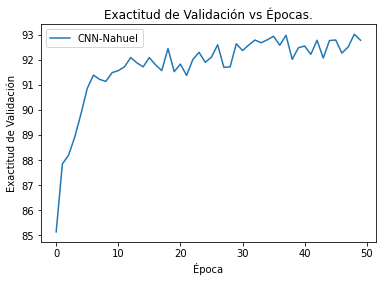

In [11]:
for model in df_nahuel['model'].unique():
    x_axis = df_nahuel[df_nahuel['model'] == model]['epoch'].values
    #train_loss = df_nahuel[df_nahuel['model'] == model]['train_loss'].values
    #train_acc = df_nahuel[df_nahuel['model'] == model]['train_accuracy'].values
    #valid_loss = df_nahuel[df_nahuel['model'] == model]['valid_loss'].values
    valid_acc = df_nahuel[df_nahuel['model'] == model]['valid_accuracy'].values
    plt.plot(x_axis - 1, valid_acc, label = "{}".format(model))
plt.xlabel("Época")
plt.ylabel("Exactitud de Validación")
plt.legend()
plt.title("Exactitud de Validación vs Épocas.")
#plt.ylim(0.004, 0.005)
plt.rcParams["figure.figsize"] = (17.5,7)
plt.show()

valid min: 0.21565805599093438
epoch: 19.0


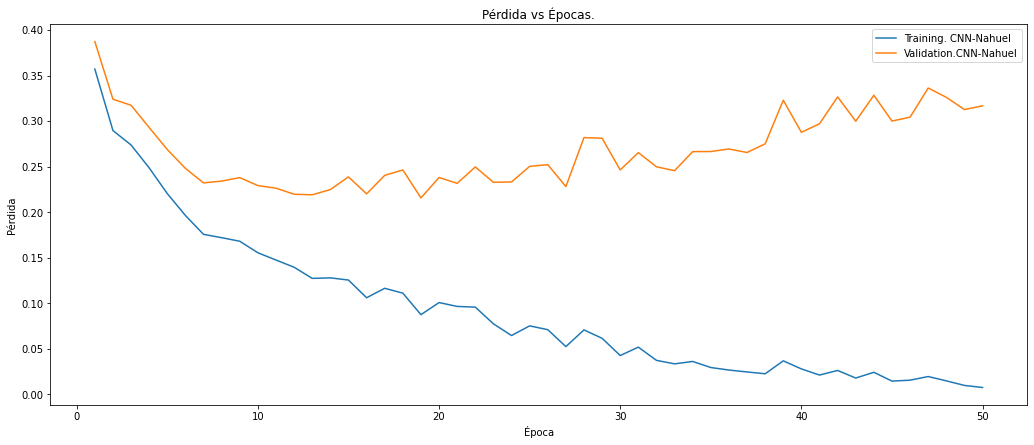

In [12]:
for model in df_nahuel['model'].unique():
    x_axis = df_nahuel[df_nahuel['model'] == model]['epoch'].values
    train_loss = df_nahuel[df_nahuel['model'] == model]['train_loss'].values
    #train_acc = df_nahuel[df_nahuel['model'] == model]['train_accuracy'].values
    valid_loss = df_nahuel[df_nahuel['model'] == model]['valid_loss'].values
    #valid_acc = df_nahuel[df_nahuel['model'] == model]['valid_accuracy'].values
    valid_min_index = np.argmin(valid_loss)
    print("valid min: {}".format(valid_loss[valid_min_index]))
    print("epoch: {}".format(x_axis[valid_min_index]))
    plt.plot(x_axis, train_loss, label = "Training. {}".format(model))
    plt.plot(x_axis, valid_loss, label = "Validation.{}".format(model))
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.title("Pérdida vs Épocas.")
    #plt.ylim(0.004, 0.005)
    plt.rcParams["figure.figsize"] = (17.5,7)
    plt.show()

In [13]:
df1_nahuel = pd.DataFrame()
    
for model in df_nahuel['model'].unique():
    # Store all values for the model.
    epoch = df_nahuel[df_nahuel['model'] == model]['epoch'].values
    train_loss = df_nahuel[df_nahuel['model'] == model]['train_loss'].values
    train_acc = df_nahuel[df_nahuel['model'] == model]['train_accuracy'].values
    valid_loss = df_nahuel[df_nahuel['model'] == model]['valid_loss'].values
    valid_acc = df_nahuel[df_nahuel['model'] == model]['valid_accuracy'].values
    
    # Get index for minimum validation loss.
    valid_min_index = np.argmin(valid_loss)
    
    # Store corresponding values in dataframe.
    df1_nahuel = df1_nahuel.append({"model": model, 
                                "epoch": epoch[valid_min_index], 
                                "train_loss": train_loss[valid_min_index],
                                "train_accuracy": train_acc[valid_min_index],
                                "valid_loss": valid_loss[valid_min_index],
                                "valid_accuracy": valid_acc[valid_min_index]},
                                ignore_index = True)

df1_nahuel.sort_values(by=['valid_accuracy'], ascending = False)

,model,epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
0,CNN-Nahuel,19.0,0.087466,96.958,0.215658,92.45


#### Re-train model for 19 epochs.

In [14]:
dff = pd.DataFrame()

# Initialize model.
model = CNN()

# Optimizer.
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

print("Model: {}-Final\n-------------------------------".format(model.name))

for epoch in range(19):
    # Train model.
    train(train_dataloader, model, loss_function, optimizer)
    # Evaluate loss function.
    train_loss, train_accuracy = test(train_dataloader, model, loss_function)
    test_loss, test_accuracy = test(test_dataloader, model, loss_function)
    if save_loss:
        # Add values to DataFrame.
        dff = dff.append({"model": "{}-Final".format(model.name), 
                        "epoch": epoch + 1, 
                        "train_loss": train_loss,
                        "train_accuracy": train_accuracy,
                        "test_loss": test_loss,
                        "test_accuracy": test_accuracy},
                        ignore_index = True)
        # Safety save.
        dff.to_pickle(r"models\safety-nahuel-final.pkl")

if save_model:
    model_filename = r"models\{}-Final.pth".format(model.name)
    torch.save(model.state_dict(), model_filename)

print("Model: {}-Final. Done!\n-------------------------------\n".format(model.name))
        
if save_loss:
    # Save DataFrame.
    dff.to_pickle(r"models\dataframe-nahuel-final.pkl")

Model: CNN-Nahuel-Final
-------------------------------
Model: CNN-Nahuel-Final. Done!
-------------------------------

